In [2]:
import pandas as pd



In [10]:
df=pd.read_csv("financeBank.csv")
df.head()
#df.shape

label                                           sentence
0      1  ['According', 'to', 'Gran', 'the', 'company', ...
1      2  ['For', 'the', 'last', 'quarter', 'of', '2010'...
2      2  ['In', 'the', 'third', 'quarter', 'of', '2010'...
3      2  ['Operating', 'profit', 'rose', 'to', 'EUR', '...
4      2  ['Operating', 'profit', 'totalled', 'EUR', '21...

### Model

In [65]:
import pandas as pd
import numpy as np
# --- Libraries ---
# - Base libs - 
import os
import numpy as np

# -Tensorflow-
import tensorflow as tf
from tensorflow.python.client import device_lib
# -Keras libs-
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from keras.utils import plot_model # pydot, graphviz are dependencies
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils

# -Plot libs-
import matplotlib.pyplot as plt
from IPython.display import SVG, display
#%matplotlib inline

### KEEP the original data

In [20]:
import numpy as np

#df.loc[df["label"]==4,"label"]=1

#df["sentence"]=sentence_list
#df=df.sample(frac=0.01, replace=False)
from nltk.corpus import wordnet

#word dictionary
word_list=[]
sentences=df["sentence"].tolist()
for sentence in sentences:
    for word in eval(sentence):
        # if wordnet.synsets(word.lower()):
            if word not in word_list:
                word_list.append(word.lower())


            
        


In [21]:
max_l=0
for sentence in sentences:
    max_l=max(len(eval(sentence)),max_l)
max_l

53

In [27]:
#how many words in a single sentence
max_len = 60
#maximum length of the word: how many characters a word contain
max_len_char = 10

words=word_list
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}


### Word characters 

In [33]:
from keras.preprocessing.sequence import pad_sequences
sentences=df.sentence
X_word=[]
for s in sentences:
    single_s=[]
    for w in eval(s):
    
       # if wordnet.synsets(w.lower()):
        single_s.append(word2idx[w.lower()])
        #else:
         #   single_s.append(word2idx["UNK"])
    X_word.append(single_s)
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
X_word.shape

(2264, 60)

In [34]:
chars = set([w_i for sentence in df.sentence for w in sentence for w_i in w])
n_chars = len(chars)
print(n_chars)

char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0


X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


77


In [66]:
y=df.label
from sklearn.model_selection import train_test_split
Y=np_utils.to_categorical(y)
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, Y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [67]:
## Define the character embedding model
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D,Flatten, Conv2D,MaxPooling1D,MaxPooling2D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop, Adam


### CHARSCNN

In [68]:
# input and embedding for words
n_words=len(words)

# define the model
model = Sequential()
#model.add(Embedding(n_words, 8, input_length=max_len))

word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=False)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=False))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                               recurrent_dropout=0.5))(emb_char)

# main CNN
x = concatenate([emb_word, char_enc],axis=1)
x = SpatialDropout1D(0.3)(x)
#x=Flatten()(x)
# main model
                                
# first feature extractor
conv1 = Conv1D(8, kernel_size=4, activation='relu')(x)
pool1 = MaxPooling1D(pool_size=2)(conv1)
flat1 = Flatten()(pool1)
# prediction output
output = Dense(3, activation='softmax')(flat1)
model = Model(inputs=[word_in, char_in], outputs=output)


model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 60, 10)       0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 60, 10, 10)   790         input_12[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 60, 20)       263060      input_11[0][0]                   
__________________________________________________________________________________________________
time_distr

In [69]:
model.compile( optimizer=Adam(0.01),loss="categorical_crossentropy",metrics=["acc"])


In [72]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr),
                    batch_size=32, epochs=10, validation_split=0.2, verbose=1)


Train on 1629 samples, validate on 408 samples
Epoch 1/10
1629/1629 [==============================] - 5s 3ms/step - loss: 0.7828 - acc: 0.6433 - val_loss: 0.5516 - val_acc: 0.7647
Epoch 2/10
1629/1629 [==============================] - 3s 2ms/step - loss: 0.4577 - acc: 0.7858 - val_loss: 0.5327 - val_acc: 0.7647
Epoch 3/10
1629/1629 [==============================] - 3s 2ms/step - loss: 0.2766 - acc: 0.8742 - val_loss: 0.5612 - val_acc: 0.7819
Epoch 4/10
1629/1629 [==============================] - 3s 2ms/step - loss: 0.1349 - acc: 0.9466 - val_loss: 0.5948 - val_acc: 0.8137
Epoch 5/10
1629/1629 [==============================] - 3s 2ms/step - loss: 0.0659 - acc: 0.9791 - val_loss: 0.6996 - val_acc: 0.7966
Epoch 6/10
1629/1629 [==============================] - 3s 2ms/step - loss: 0.0372 - acc: 0.9883 - val_loss: 0.6743 - val_acc: 0.8235
Epoch 7/10
1629/1629 [==============================] - 3s 2ms/step - loss: 0.0196 - acc: 0.9932 - val_loss: 0.8227 - val_acc: 0.8015
Epoch 8/10
1629

In [73]:
model.evaluate([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te))

227/227 [==============================] - 0s 470us/step


[0.9119150460028963, 0.8149779738308575]

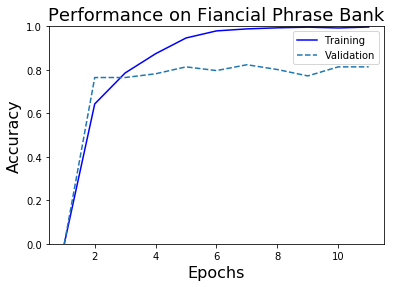

In [77]:
# --- Plotting data/training model ---
import matplotlib.pyplot as plt

# Get loss function
loss = history.history['acc']
loss=[0]+list(loss)
val_loss = history.history['val_acc']
val_loss=[0]+list(val_loss)

# Setup grid for plotting
epochs =range(1, len(loss) + 1)
#epochs=[0]+list(epochs)
# Plot
plt.close("all")
plt.plot(epochs, loss, 'b', label='Training')
plt.plot(epochs, val_loss,'--', label='Validation')
plt.ylim(0,1)
plt.title('Performance on Fiancial Phrase Bank',fontsize=18)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.legend()
plt.savefig("finance_accuray.png")
plt.show()

### backup

 --- Preparing the Data ---
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np
maxlen=40

sentence_num=[]
for st in df["sentence"].tolist():
    single_sentence=[]
    for w in st:
        single_sentence.append(vocab[w])
       
    #single_sentence=sequence.pad_sequences(np.array(single_sentence).T, maxlen = maxlen)
    
    #single_sentence=single_sentence.T
        
    sentence_num.append(single_sentence)



print('Pad sequence (sample x time)')
input_all = sequence.pad_sequences(sentence_num, maxlen = maxlen)
input_all.shape

#split to train and test data
import random
samples=range(len(input_all))
num_train=int(len(input_all)*0.7)
train_index=random.sample(samples,num_train)
test_index=[i for i in samples if i not in train_index]
input_train=input_all[train_index]
input_test=input_all[test_index]



y_train=df["label"].values[train_index]
y_test=df["label"].values[test_index]

max_features=100000

model = Sequential()
model.add(Embedding(max_features, 300))
#model.add(SimpleRNN(12))
#model.add(GRU(32))
model.add(LSTM(5))
model.add(Dense(1, activation ='sigmoid'))
model.summary()

#Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])


# Verbose=0 -> to avoid jupyter notebook freezing
history = model.fit(input_train, y_train, 
                    epochs = 5, batch_size = 32, 
                    verbose=1)

model.evaluate(input_test,y_test)